<h1><center>Bayesian Computation project, Spring 2019</center></h1>
<center>Charles Dufour, Sciper: 257587</center>


In [1]:
#to make life easier
%load_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings

import plotly.offline as py
py.init_notebook_mode(connected=False)

<body>
  <p style="color:red";>Due to a scipy latest update, may have to run twice the cell below</p>
</body>


[See issue on the Github](https://github.com/HIPS/autograd/issues/501) for a quick fix

In [3]:
from src.models import Model, Prior, Conditional_model
from src.sampling import Metropolis_Hastings as MH
from src.helpers import samples_exploration,big_plot,reset_plot, compare_samples_MH,visualisation
from src.optimization import gradient_descent as GD
import src.approximation.Laplace as Laplace

In [4]:
import src.maths.func_stats as fstats

# Load the data

In [5]:
df = pd.read_csv("data/wages.dat", 
                 sep="\s+")
y_not_normalized = df.LNWAGE.values.copy()

#normalization of continuous variables
df.LNWAGE = (df.LNWAGE - np.mean(df.LNWAGE.values))/np.std(df.LNWAGE.values)
df.ED =(df.ED - np.mean(df.ED.values))/np.std(df.ED.values)
df.EX =(df.EX - np.mean(df.EX.values))/np.std(df.EX.values)

#dropping correlated variables
df = df.drop(columns = ["EXSQ","AGE"], axis = 1)


#building predictors and response matrices
predictors_name = np.array(['ED', 'SOUTH', 'NONWH', 'HISP', 'FE', 'MARR', 'MARRFE', 'EX',
        'UNION', 'MANUF', 'CONSTR', 'MANAG', 'SALES', 'CLER',
        'SERV', 'PROF'])
predictors = df[predictors_name]
y = df.LNWAGE.values
X = predictors.values

#splitting train and test
# X,X_test are the covariates
# Y,Y_test are the normalized response
# y,y_test are the original reponse
X, X_test, Y, Y_test,  y, y_test = train_test_split(X, y, y_not_normalized, test_size=0.2, random_state=42)

# Exploratory analysis

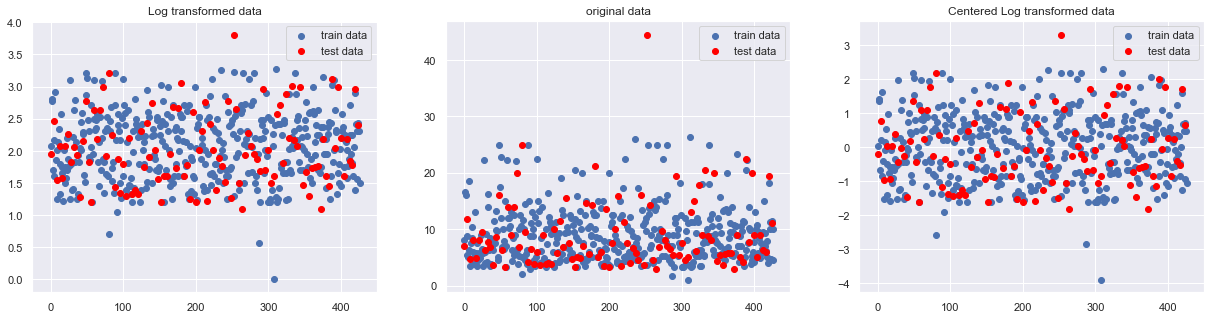

In [6]:
big_plot(21,5)
plt.subplot(132)
plt.scatter(np.arange(len(y)), np.exp(y), label = "train data")
plt.scatter(4*np.arange(len(y_test)), np.exp(y_test), label = "test data", color = "red")
plt.title("original data")
plt.legend()
plt.subplot(131)
plt.scatter(np.arange(len(y)), y, label = "train data")
plt.scatter(4*np.arange(len(y_test)), y_test, label = "test data", color = "red")
plt.title("Log transformed data")
plt.legend()
plt.subplot(133)
plt.scatter(np.arange(len(Y)), Y, label = "train data")
plt.scatter(4*np.arange(len(Y_test)), Y_test, label = "test data", color = "red")
plt.title("Centered Log transformed data")
plt.legend()
plt.show()

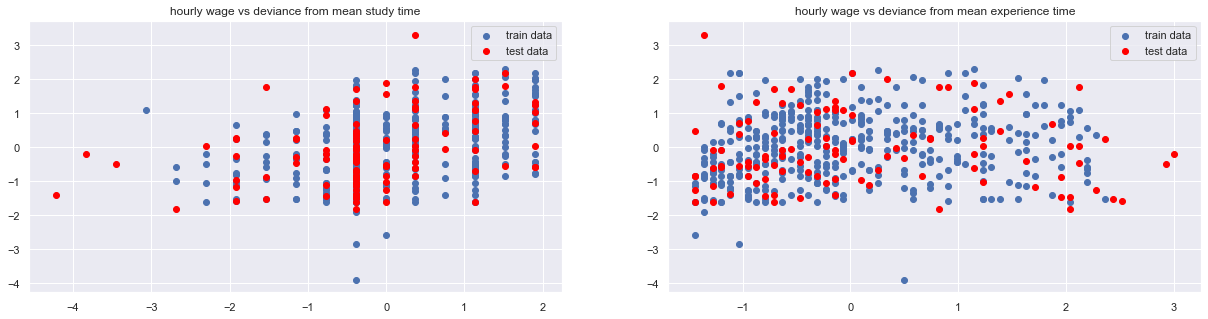

In [7]:
plt.subplot(121)
plt.scatter(X[:,0],Y,label = "train data")
plt.scatter(X_test[:,0],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean study time")
plt.subplot(122)
plt.scatter(X[:,7],Y, label = "train data")
plt.scatter(X_test[:,7],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean experience time")
plt.savefig("regressors.png",dpi = 300, bbox_inches = "tight")
plt.show()

# Create the models

`model_gausian`:

- Conditional model:
$$ Y = X\beta + \epsilon$$
$$\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$$

- Priors:
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$
$$\sigma \sim exp(\lambda) \quad \lambda = 2 $$


`model_student`:
    
- conditional model:
$$ Y = X\beta + \epsilon$$


$$\varepsilon_i \sim \text{ Student of degree d }$$


- priors
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$


$$\text{ d } \sim \Gamma(2,4) $$    

In [8]:
model_gaussian = Model.Model(Prior.Gaussian_exp_prior,Conditional_model.Gaussian, Prior = [0,3,2], data = X, response = Y, additional_param = 1)
model_student = Model.Model(Prior.Gaussian_gamma_prior, Conditional_model.Student, Prior = [0,3,2,1/4], data = X, response = Y, additional_param = 1)

## Obtaining estimates of the parameters

## using Laplace approximation with different optimization methods

#### using vanilla gradient descent

Update step:
   $$ \theta_{n+1} = \theta_n - \eta\nabla f(\theta_n)$$

In [9]:
Laplace.laplace_approx(model_gaussian,method =  GD.vanilla_gd)

Progress : [====================] 100% Done...
   duration: 0:00:11


In [10]:
Laplace.laplace_approx(model_student,method =  GD.vanilla_gd)

Progress : [====================] 100% Done...
   duration: 0:00:15


#### using line search

Update step:
   $$ \theta_{n+1} = \theta_n - \eta\nabla f(\theta_n)$$
additional condition: accept if 
$$f(\theta_{n+1})< f(\theta_n) -\eta\epsilon||\nabla_\theta f(\theta_n)||_2^2$$

In [11]:
Laplace.laplace_approx(model_gaussian,method =  GD.line_search_gd,name_method="line search")

Progress : [====================] 100% Done...
 converged early at iteration 7692  duration: 0:00:14


In [12]:
Laplace.laplace_approx(model_student,method =  GD.line_search_gd,name_method="line search")

Progress : [====================] 100% Done...
   duration: 0:00:18


#### using Wolfe condition to adpat the step size

Check the Wolfe condition and adapt the step size accordingly: $p_k = \nabla f(x_k)$,   $ \quad 0<c_1<c_2<1$

if $f(x_k + \alpha_kp_k) \leq f(x_k) + c_1\alpha_kp_k^T\nabla f(x_k)$  then reduce step size $\alpha_k$

if $-p_k^T\nabla f(x_k+\alpha_kp_k) \leq -c_2p_k^T\nabla f(x_k)$ then increase step size 

else accept update

In [13]:
Laplace.laplace_approx(model_gaussian,method =  GD.Wolfe_cond_gd,name_method="Wolfe conditions")

Progress : [====================] 100% Done...
   duration: 0:00:29


In [14]:
Laplace.laplace_approx(model_student,method =  GD.Wolfe_cond_gd,name_method="Wolfe conditions")

Progress : [====================] 100% Done...
   duration: 0:00:39


## Using Metropolis Hastings

#### with gaussian random walk

Progress : [====================] 100% Done...
  Acceptance rate : 16.1%  (advised values between 10% and 50%)
  duration: 0:00:18
iterations


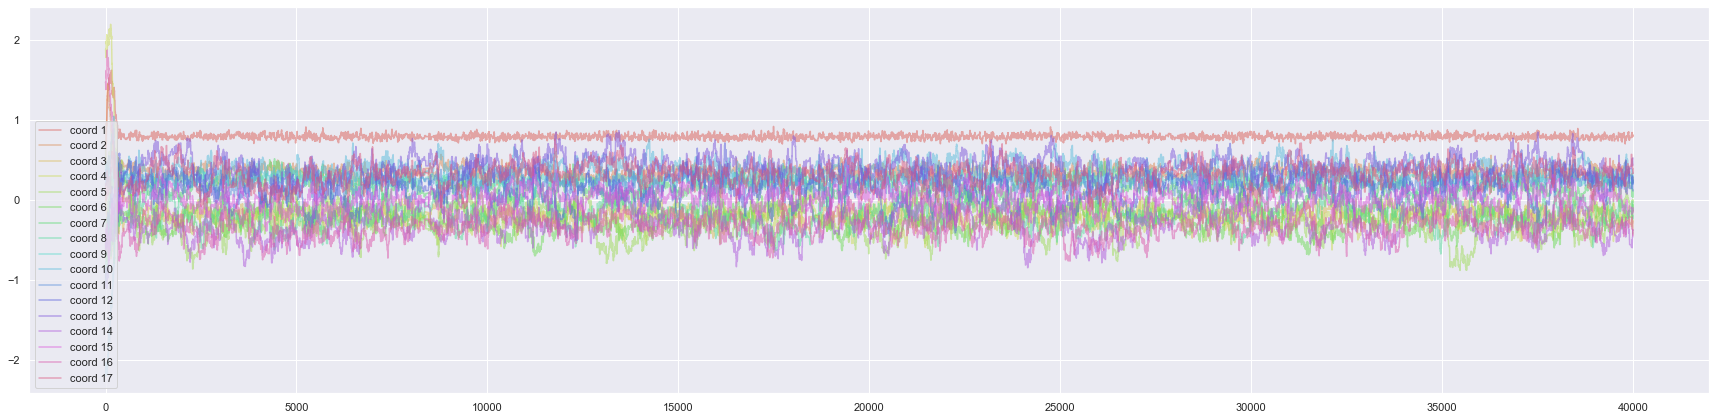

In [15]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_gaussian.size)
    initial[0]=0.5
    step_size = 0.05*np.ones(model_gaussian.size)
    step_size[0]=0.035
    samples_gaussian_rw = MH.random_walk_MH(model_gaussian, max_iter = 40000, verbose = True, step_size = step_size, initial = initial, RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 39.7%  (advised values between 10% and 50%)
  duration: 0:00:21
iterations


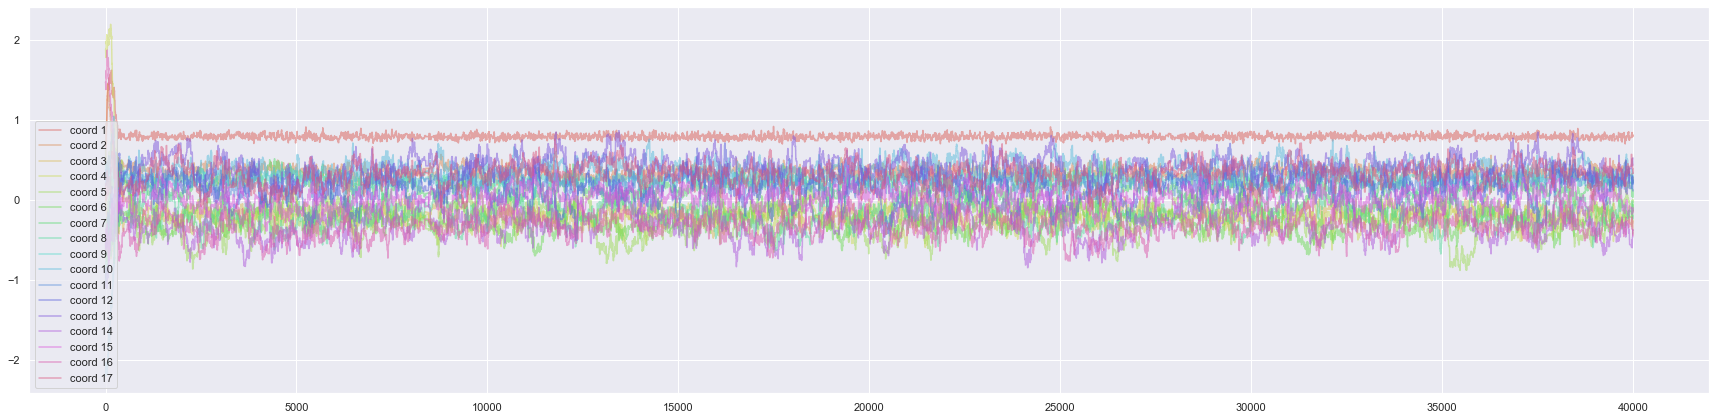

In [16]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_student.size)
    initial[0]= 20
    step_size = np.ones_like(initial)*0.035
    step_size[0] = 5
    samples_student_rw = MH.random_walk_MH(model_student, max_iter = 40000, verbose = True, step_size = step_size, initial = initial,RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

#### with Langevin correction

Progress : [====================] 100% Done...
  Acceptance rate : 31.4%                 (advised values between 10% and 50%)
  duration: 0:02:33
iterations


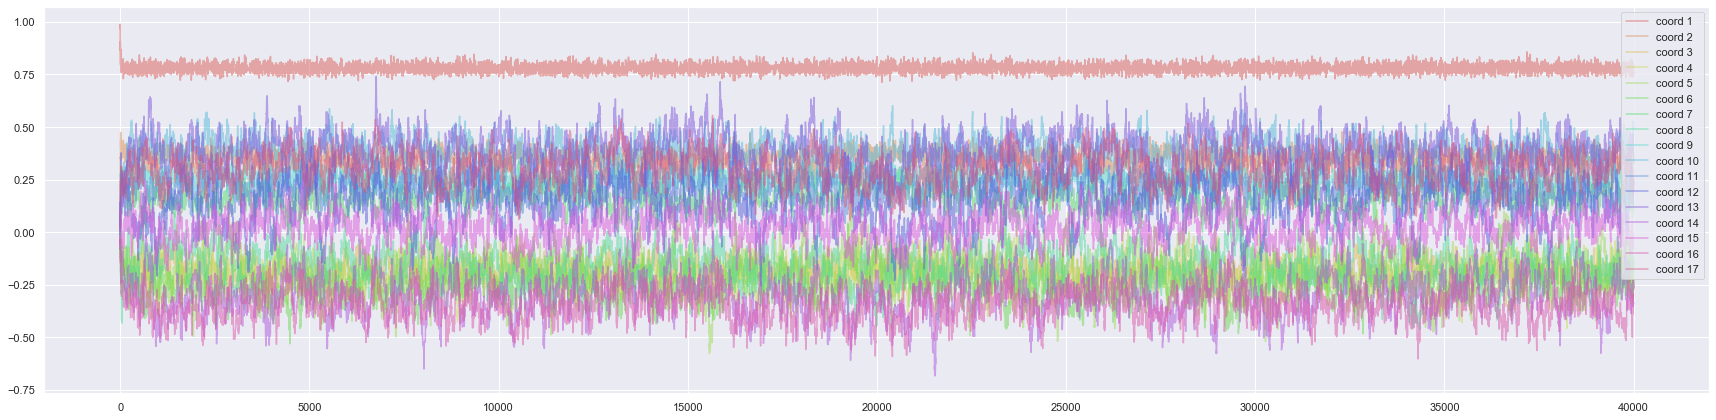

In [17]:
with warnings.catch_warnings(record=True):
    initial = np.zeros(model_gaussian.size)
    initial[0]=1
    samples_gaussian_langevin = MH.Langevin_MH(model_gaussian, max_iter = 40000, initial = initial,verbose = True, tau = 4*1e-4,RETURN=True)
    samples_exploration(samples_gaussian_langevin,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 25.8%                 (advised values between 10% and 50%)
  duration: 0:03:20
iterations


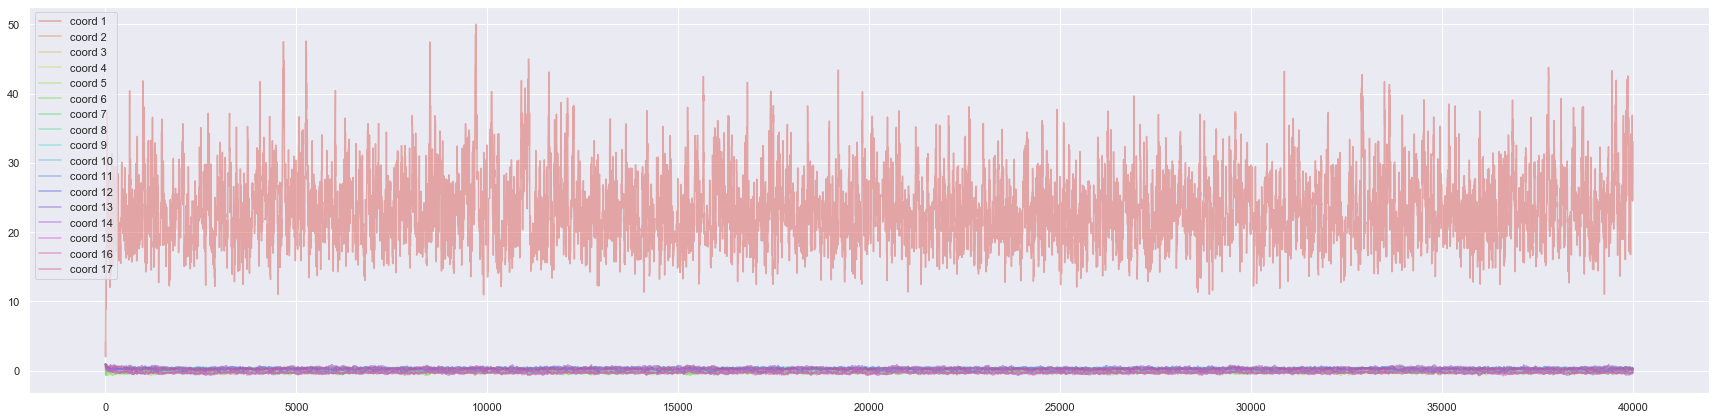

In [18]:
with warnings.catch_warnings(record=True):
    initial = np.ones(model_student.size)
    initial[0]=12
    step_size = np.ones(model_student.size)
    step_size[0] = 100
    samples_student_langevin = MH.Langevin_MH(model_student, max_iter = 40000, initial = initial, tau = 1e-3, RETURN=True,step_size = step_size)
    samples_exploration(samples_student_langevin,correlation=False, distribution = False)

#### Using Metropolis Hastings within gibbs

This is done to see if there is any gain in computational time

default batch is 5
Progress : [====================] 100% Done...
  Acceptance rate : 49.4%  (advised values between 10% and 50%)
  duration: 0:00:20
iterations


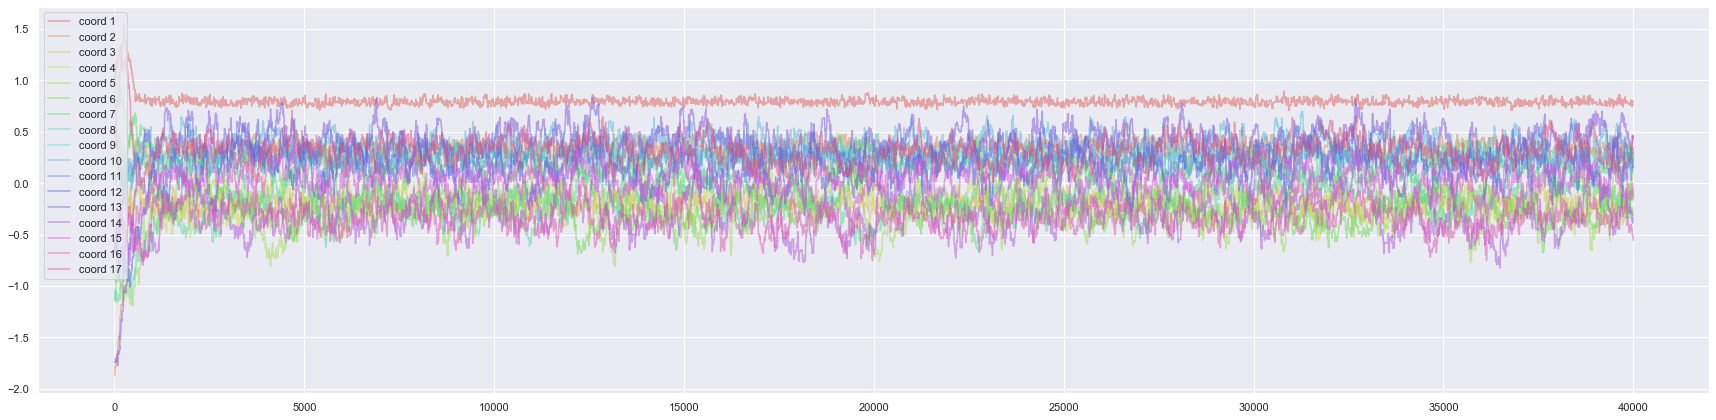

In [19]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_gaussian.size)
    initial[0]=0.5
    step_size = 0.05*np.ones(model_gaussian.size)
    step_size[0]=0.035
    samples_gaussian_gibbs = MH.MH_whithin_Gibbs(model_gaussian, max_iter = 40000, verbose = True, step_size = step_size, initial = initial, RETURN= True)
    samples_exploration(samples_gaussian_gibbs,correlation=False,distribution=False)

default batch is 5
Progress : [====================] 100% Done...
  Acceptance rate : 59.7%  (advised values between 10% and 50%)
  duration: 0:00:21
iterations


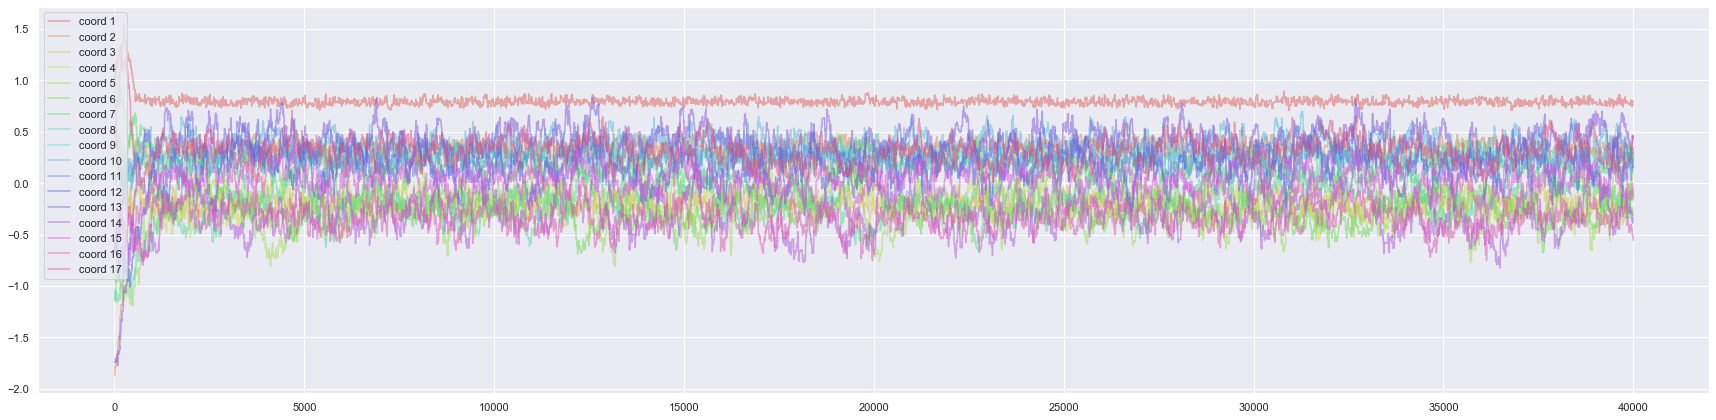

In [20]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_student.size)
    initial[0]= 20
    step_size = np.ones_like(initial)*0.05
    step_size[0] = 5
    samples_student_gibbs = MH.MH_whithin_Gibbs(model_student, max_iter = 40000, verbose = True, step_size = step_size, initial = initial,RETURN= True)
    samples_exploration(samples_gaussian_gibbs,correlation=False,distribution=False)

### extraction of the estimates from the models

we use point estimates, precisely the mean of the distribution

In [23]:
r_gaussian = model_gaussian()
r_gaussian.T

error         ED     SOUTH     NONWH  \
Laplace with vanilla gd        0.773617  0.351707 -0.185607 -0.204573   
Laplace with line search       0.773617  0.351707 -0.185607 -0.204572   
Laplace with Wolfe conditions  0.793546  0.335745 -0.257839 -0.181027   
MH_vanilla_mean                0.790714  0.348480 -0.185985 -0.208770   
MH_Langevin_mean               0.780488  0.351416 -0.187249 -0.207523   
MH_Gibbs_mean                  0.791349  0.350520 -0.192345 -0.188881   

                                   HISP        FE      MARR    MARRFE  \
Laplace with vanilla gd       -0.212708 -0.239071  0.169968 -0.162220   
Laplace with line search      -0.212706 -0.239066  0.169971 -0.162225   
Laplace with Wolfe conditions  0.234199 -0.519991 -0.062918  0.093940   
MH_vanilla_mean               -0.245784 -0.239549  0.169225 -0.164614   
MH_Langevin_mean              -0.201270 -0.237873  0.172911 -0.162853   
MH_Gibbs_mean                 -0.230930 -0.247070  0.167767 -0.149639   

                                     EX     UNION     MANUF    CONSTR  \
Laplace with vanilla gd        0.258266  0.385554  0.212764  0.141789   
Laplace with line search       0.258266  0.385553  0.212762  0.141787   
Laplace with Wolfe conditions  0.272369  0.393092  0.336011  0.533428   
MH_vanilla_mean                0.258797  0.380449  0.212105  0.129550   
MH_Langevin_mean               0.258035  0.382664  0.212480  0.139056   
MH_Gibbs_mean                  0.256822  0.378809  0.205070  0.162326   

                                  MANAG     SALES      CLER      SERV  \
Laplace with vanilla gd        0.393543 -0.297681  0.025755 -0.345083   
Laplace with line search       0.393539 -0.297685  0.025751 -0.345086   
Laplace with Wolfe conditions  0.614766  0.174680  0.260062 -0.099339   
MH_vanilla_mean                0.407157 -0.286196  0.025044 -0.337056   
MH_Langevin_mean               0.389081 -0.298581  0.022186 -0.345355   
MH_Gibbs_mean                  0.404547 -0.292921  0.026549 -0.340512   

                                   PROF  
Laplace with vanilla gd        0.297533  
Laplace with line search       0.297529  
Laplace with Wolfe conditions  0.533979  
MH_vanilla_mean                0.312798  
MH_Langevin_mean               0.298264  
MH_Gibbs_mean                  0.308485

In [24]:
r_student = model_student()
r_student.T

error         ED     SOUTH     NONWH  \
Laplace with vanilla gd         6.721894  0.339475 -0.204338 -0.240538   
Laplace with line search        6.725378  0.339587 -0.204327 -0.240380   
Laplace with Wolfe conditions  10.823977  0.339917 -0.201215 -0.229065   
MH_vanilla_mean                24.461791  0.342497 -0.199597 -0.209617   
MH_Langevin_mean               23.264656  0.342709 -0.194575 -0.220395   
MH_Gibbs_mean                  24.581086  0.345126 -0.204113 -0.196791   

                                   HISP        FE      MARR    MARRFE  \
Laplace with vanilla gd       -0.296998 -0.265096  0.207160 -0.187935   
Laplace with line search      -0.296726 -0.264316  0.207668 -0.188720   
Laplace with Wolfe conditions -0.276358 -0.257497  0.198861 -0.183202   
MH_vanilla_mean               -0.270980 -0.249316  0.191156 -0.178766   
MH_Langevin_mean              -0.253832 -0.243133  0.189334 -0.181951   
MH_Gibbs_mean                 -0.268863 -0.255354  0.182970 -0.167916   

                                     EX     UNION     MANUF    CONSTR  \
Laplace with vanilla gd        0.264380  0.365804  0.205182  0.122456   
Laplace with line search       0.264390  0.365693  0.204960  0.122074   
Laplace with Wolfe conditions  0.262451  0.369417  0.205380  0.125425   
MH_vanilla_mean                0.262456  0.367460  0.213646  0.121498   
MH_Langevin_mean               0.259480  0.381261  0.206415  0.124426   
MH_Gibbs_mean                  0.258810  0.377909  0.203038  0.202311   

                                  MANAG     SALES      CLER      SERV  \
Laplace with vanilla gd        0.503366 -0.280604  0.059452 -0.359521   
Laplace with line search       0.502690 -0.281299  0.058887 -0.360042   
Laplace with Wolfe conditions  0.483618 -0.286252  0.050555 -0.355084   
MH_vanilla_mean                0.446600 -0.290691  0.041351 -0.363530   
MH_Langevin_mean               0.453664 -0.300804  0.037641 -0.353758   
MH_Gibbs_mean                  0.446323 -0.273910  0.042986 -0.348682   

                                   PROF  
Laplace with vanilla gd        0.312968  
Laplace with line search       0.312307  
Laplace with Wolfe conditions  0.311113  
MH_vanilla_mean                0.313451  
MH_Langevin_mean               0.303583  
MH_Gibbs_mean                  0.313149

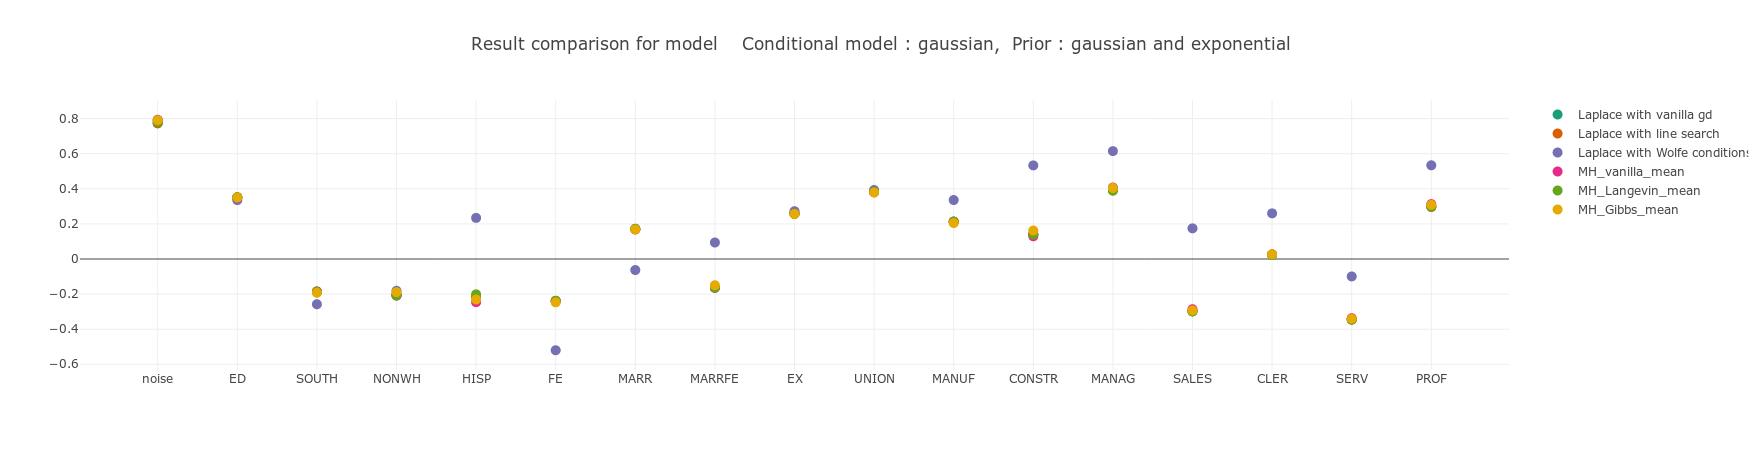

In [25]:
visualisation(r_gaussian,model_gaussian)

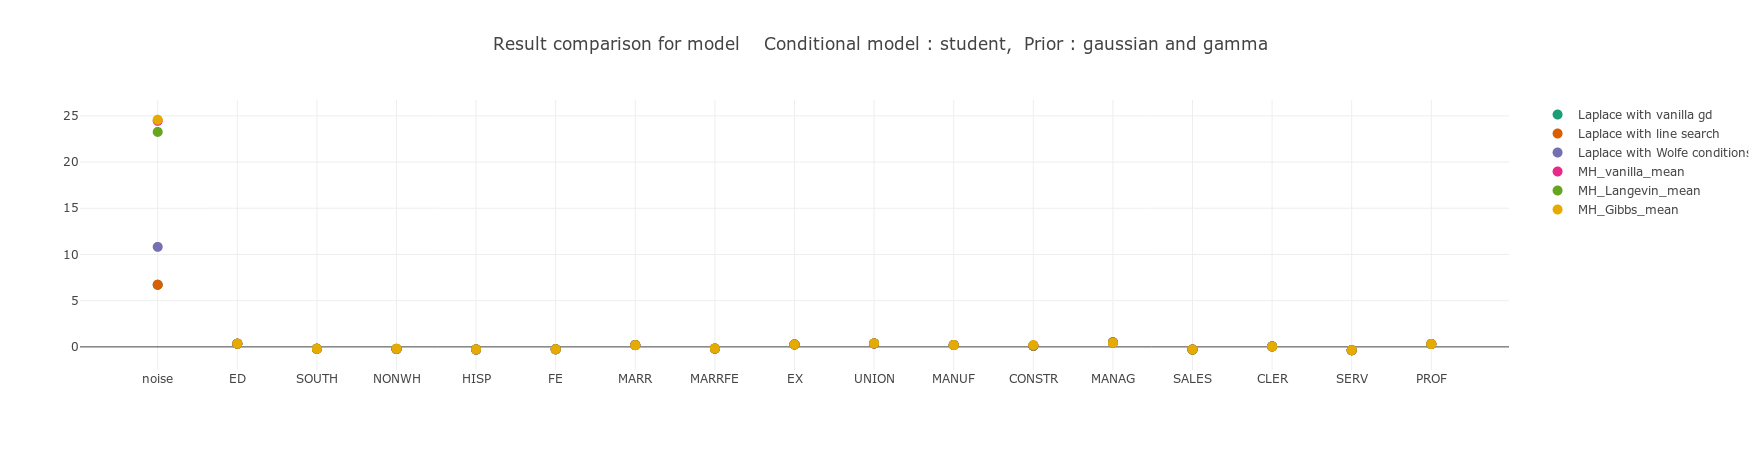

In [26]:
visualisation(r_student,model_student)

## Accuracy of the prediction

In order to predict, we have to use : $$ f(y| D = d) = \int f(y,\theta|D = d)d\theta = \int f(y|\theta)f(\theta|D=d)d\theta$$
Since we suppose our data are iid, the dependence of $y$ to $D$ is only through $\theta$



Supposing we want to approximate $y$ by its mean in the case of our first model, with the gaussian noise, gaussian prior on $\beta$ and exponential prior on $\sigma$:

\begin{align} \mathbb{E}[y|D=d] &= \int y f(y|D=d)dy \\
&= \int y \int f(y|\theta)f(\theta|D=d)d\theta dy \\
&= \int\int y f(y|\theta)f(\theta|D=d)d\theta dy\\
&= \int\left( \int y f(y|\theta)dy \right) f(\theta|D=d)d\theta \\
&= \int x^T\beta f(\theta|D=d)d\theta \\ 
&= \mathbb{E}_{\theta \sim \theta|D=d}[x^T\beta]\\
&= x^T \widehat{\beta}
\end{align}

So supposing we can switch the integrals (using Fubini since both functions are positive (densities) and the integral $\int y f(y|\theta)f(\theta|D=d)d\theta dy $ is finite ), the point prediction can be done by either marginalizing out the $\theta$, or by first finding the "optimal" theta and then predicting the mean of the conditional model. This is logic given that the marginalization of the $\theta$ is there because we do not know the distribution of the $\theta$, but only its distribution. But if we are interested in a point estimate, this inflation in the uncertainty of our precision is not directly usefull.


For our second model, the same development holds.

Otherwise we could just use the samples from the previous run of our Metropolis Hasting algorithms and for each $\theta$ sampled, compute a prediction $x^T\theta$ and then compute a statistic on these. 

When using the samples from Metropolis-Hastings algorithm, we will make a gaussian approximation of our posterior, so the MAP will be the mean or the median. Since this is an approximation, we will use both mean and median to see if there is any discrepancies in our reasonning.

In [27]:
errors_gaussian = pd.DataFrame()
for name in r_gaussian.columns:
    beta = r_gaussian[name].values[1:]
    errors_gaussian[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_gaussian.index = ["error on test","error on train"]
errors_gaussian.T

error on test  error on train
Laplace with vanilla gd             0.685706        0.613765
Laplace with line search            0.685706        0.613765
Laplace with Wolfe conditions       0.681076        0.627020
MH_vanilla_mean                     0.685329        0.613503
MH_Langevin_mean                    0.685716        0.614008
MH_Gibbs_mean                       0.685099        0.613410

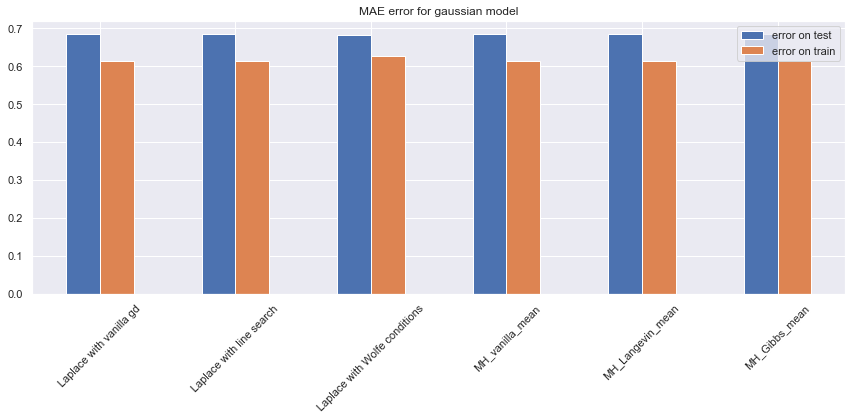

In [95]:
big_plot(12,6)
errors_gaussian.T.plot.bar()
plt.xticks(rotation= 45)
plt.title("MAE error for gaussian model")
plt.tight_layout()
plt.savefig("results/gaussian_accuracy.png", dpi = 300,bbox_inches = "tight")
reset_plot()

In [29]:
errors_student = pd.DataFrame()
for name in r_student.columns:
    beta = r_student[name].values[1:]
    errors_student[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_student.index = ["error on test","error on train"]
errors_student.T

error on test  error on train
Laplace with vanilla gd             0.685287        0.609907
Laplace with line search            0.685328        0.609908
Laplace with Wolfe conditions       0.685170        0.610570
MH_vanilla_mean                     0.685790        0.611049
MH_Langevin_mean                    0.685399        0.611443
MH_Gibbs_mean                       0.685137        0.610890

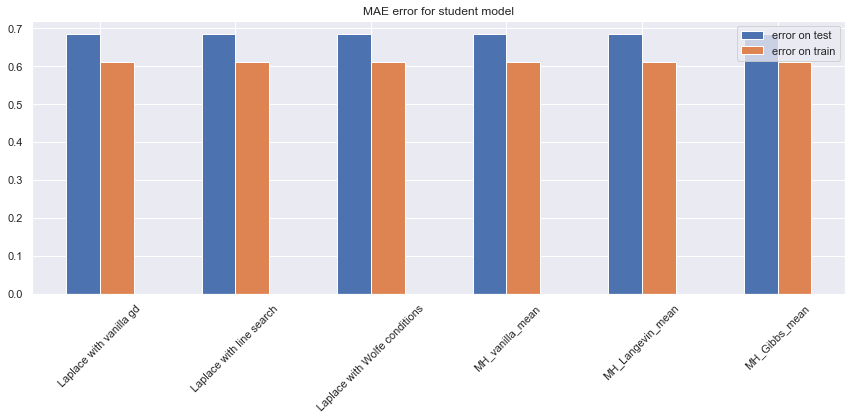

In [30]:
big_plot(12,6)
errors_student.T.plot.bar()
plt.xticks(rotation=45)
plt.title("MAE error for student model")
plt.tight_layout()
plt.savefig("results/student_accuracy.png", dpi = 300,bbox_inches = "tight")
reset_plot()

#### Marginalization of the $\theta$

Example of marginalization of the $\theta$ parameter and taking the MAP estimator on the posterior predictive density

We only do it for the gaussian model since it is quite heavy computationally speaking

In [181]:
from scipy.stats import norm as cheat_norm

In [188]:
samples_gaussian = [samples_gaussian_rw[1000:,], samples_gaussian_langevin[1000:,], samples_gaussian_gibbs[1000:,]]

In [189]:
y_grid = np.arange(-3,3.01,0.1)
scores = []
for S in samples_gaussian:
    y_pred = []
    for i,x_test in enumerate(X_test):
        #only taking the beta
        means = np.dot(S[:,1:],x_test)
        #exctraction of the sigma
        variances = S[:,1]
        s = S.shape[0]
        y_inter = np.repeat(y_grid,s, axis = 0)
        y_inter = y_inter.reshape(len(y_grid),s)
        density = np.mean(cheat_norm.pdf(y_inter, loc = means, scale = variances),axis = 1)
        y_pred.append(np.argmax(density))
    actual_prediction = [y_grid[p] for p in y_pred]
    scores.append(np.sum(np.abs(actual_prediction-Y_test))/len(Y_test))

In [190]:
scores

[0.6863794604177141, 0.6863794604177141, 0.683575722099957]

This gives the same approximation as in the plots above, confirming our first method

# Classification 

`multilogi`:

- Conditional model
$$\mathbb{P}\left(Y=1|X\right) = \frac{e^{X^T\beta}}{1+e^{X^T\beta}}$$

- Prior:
$$\beta \sim N(0,3^2I) $$

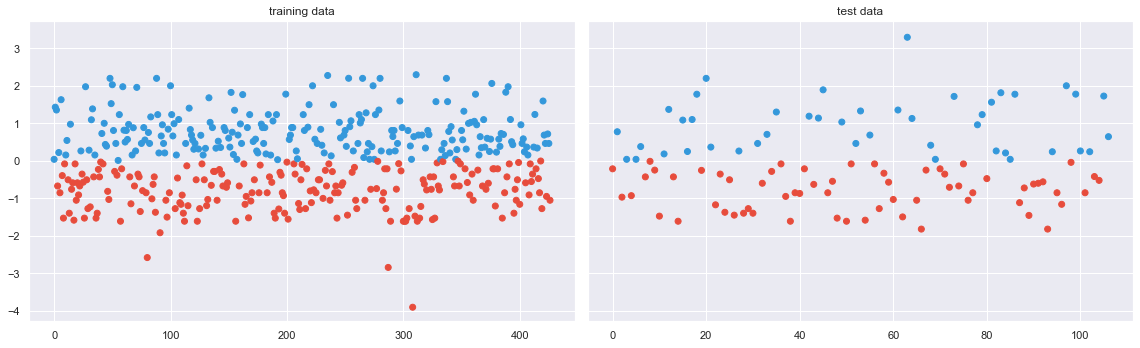

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

inter = Y
classes = inter.copy()
classes[Y >= 0] = 0
classes[Y < 0 ]= 1

#flatui = ["#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
flatui = ["#3498db", "#e74c3c", "#34495e", "#2ecc71"]

def convert(n): 
    return flatui[int(n)]
colors = list(map(convert, classes) )

axs[0].scatter(np.arange(0,X.shape[0]),Y, c = colors)
axs[0].set_title("training data")


inter = Y_test
classes_test = inter.copy()
classes_test[Y_test >= 0] = 0
classes_test[Y_test < 0 ]= 1
colors = list(map(convert, classes_test) )


axs[1].scatter(np.arange(0,X_test.shape[0]),Y_test, c = colors)
axs[1].set_title("test data")

plt.tight_layout()
plt.show()

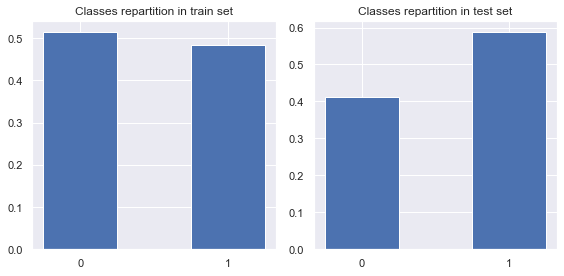

In [32]:
plt.subplot(121)
plt.bar([0.4,0.8],[len(classes[classes==0])/len(classes),len(classes[classes==1])/len(classes)],width = 0.2)
plt.xticks([0.4,0.8],[0,1])
plt.title("Classes repartition in train set")
plt.subplot(122)
plt.bar([0.4,0.8],[len(classes_test[classes_test==0])/len(classes_test),len(classes_test[classes_test==1])/len(classes_test)],width = 0.2)
plt.xticks([0.4,0.8],[0,1])
plt.title("Classes repartition in test set")
plt.tight_layout()
plt.show()

adding an intercept

In [33]:
X_intercept = np.append(X, np.ones((X.shape[0],1)), axis = 1)
X_intercept_test = np.append(X_test, np.ones((X_test.shape[0],1)), axis = 1)

In [34]:
multilogi = Model.Model(Prior.Gaussian_prior,Conditional_model.Multilogistic,data = X_intercept,response = classes, Prior = [0,3*np.ones(17)],cond_model = [2])

In [35]:
Laplace.laplace_approx(multilogi,method =  GD.vanilla_gd)

Progress : [====================] 100% Done...
   duration: 0:00:06


In [36]:
Laplace.laplace_approx(multilogi,method =  GD.line_search_gd,name_method="line search")

Progress : [====================] 100% Done...
   duration: 0:00:08


In [37]:
Laplace.laplace_approx(multilogi,method =  GD.Wolfe_cond_gd,name_method="Wolfe conditions")

Progress : [====================] 100% Done...
   duration: 0:00:11


Progress : [====================] 100% Done...
  Acceptance rate : 34.4%  (advised values between 10% and 50%)
  duration: 0:00:16
iterations


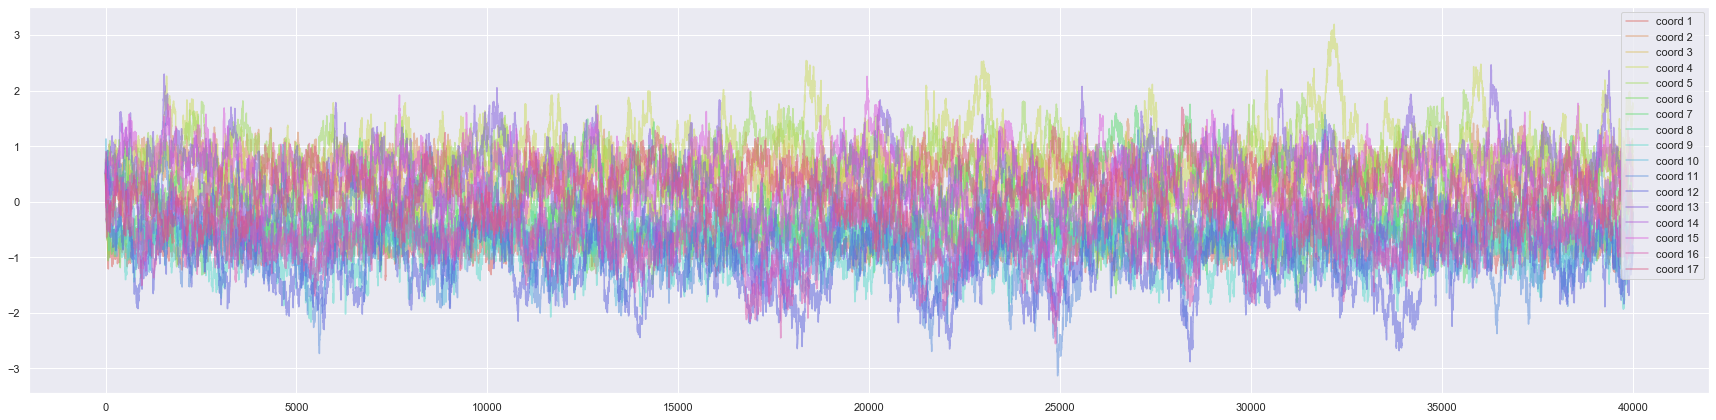

In [38]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.5
    samples_classification_rw = MH.random_walk_MH(multilogi, max_iter = 40000, verbose = True, step_size = 1e-1, initial = initial, RETURN=True)
    samples_exploration(samples_classification_rw, distribution=False, correlation= False)

Progress : [====================] 100% Done...
  Acceptance rate : 15.7%                 (advised values between 10% and 50%)
  duration: 0:00:56
iterations


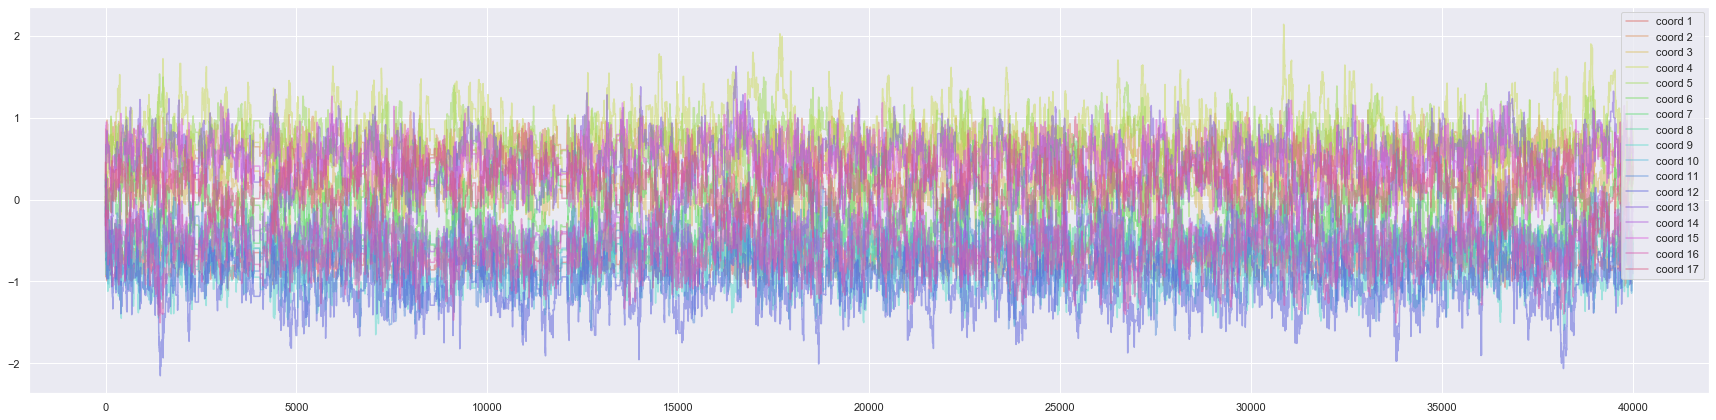

In [39]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.1
    samples_classification_langevin = MH.Langevin_MH(multilogi, max_iter = 40000, verbose = True, initial = initial, tau = 1e-2,RETURN=True)
    samples_exploration(samples_classification_langevin, distribution=False, correlation= False)

default batch is 5
Progress : [====================] 100% Done...
  Acceptance rate : 64.8%  (advised values between 10% and 50%)
  duration: 0:00:18
iterations


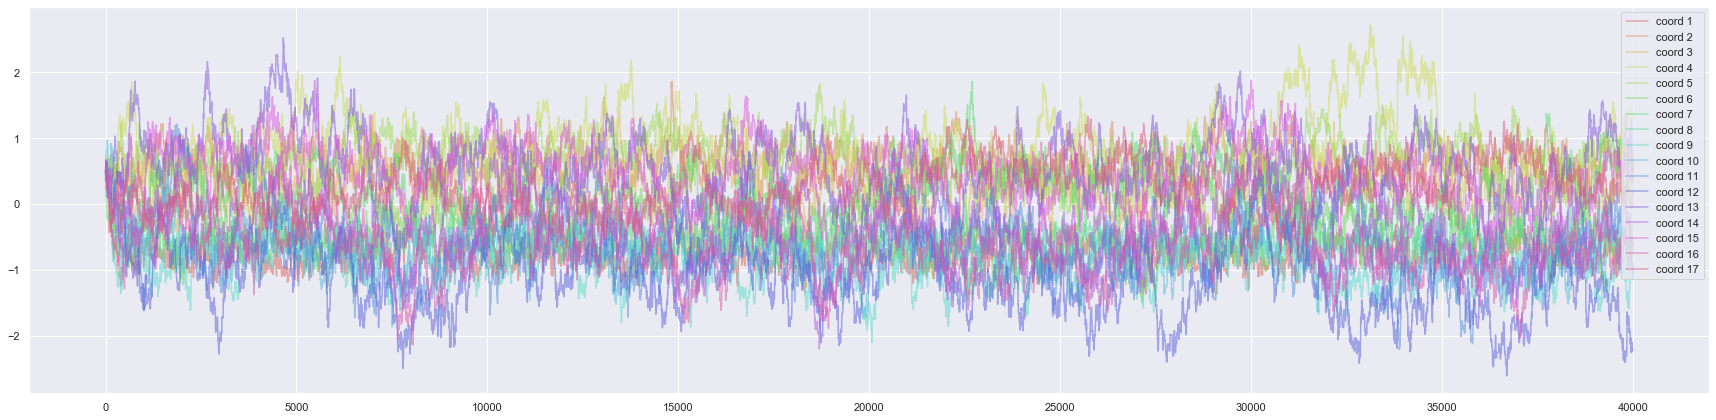

In [40]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.5
    samples_classification_gibbs = MH.MH_whithin_Gibbs(multilogi, max_iter = 40000, verbose = True, step_size = 1e-1, initial = initial, RETURN=True)
    samples_exploration(samples_classification_gibbs, distribution=False, correlation= False)

In [41]:
r_multilogi = multilogi()
r_multilogi.T

error         ED     SOUTH     NONWH  \
Laplace with vanilla gd       -0.720665  0.610288  0.172875  0.833248   
Laplace with line search      -0.755565  0.611102  0.223469  0.844874   
Laplace with Wolfe conditions -0.727635  0.615014  0.172437  0.725320   
MH_vanilla_mean               -0.770333  0.633027  0.174672  0.805385   
MH_Langevin_mean              -0.744478  0.622516  0.171423  0.773794   
MH_Gibbs_mean                 -0.769055  0.655246  0.156926  0.835220   

                                   HISP        FE      MARR    MARRFE  \
Laplace with vanilla gd        0.641248 -0.394125  0.040971 -0.538788   
Laplace with line search       0.896604 -0.188059 -0.313975 -0.576805   
Laplace with Wolfe conditions  0.667839 -0.374790  0.005168 -0.544640   
MH_vanilla_mean                0.677763 -0.404492  0.017237 -0.571040   
MH_Langevin_mean               0.649501 -0.390541  0.026639 -0.556026   
MH_Gibbs_mean                  0.616089 -0.473257  0.118178 -0.572755   

                                     EX     UNION     MANUF    CONSTR  \
Laplace with vanilla gd       -0.912230 -0.712626 -0.528356 -1.087353   
Laplace with line search      -0.888089 -0.617978 -0.362228 -0.920793   
Laplace with Wolfe conditions -0.906195 -0.710703 -0.560662 -1.065590   
MH_vanilla_mean               -0.985930 -0.763861 -0.736831 -1.156859   
MH_Langevin_mean              -0.932597 -0.709709 -0.572488 -1.080377   
MH_Gibbs_mean                 -0.922751 -0.736595 -0.594928 -1.147458   

                                  MANAG     SALES      CLER      SERV  \
Laplace with vanilla gd        0.396070 -0.456843  0.413025 -0.677229   
Laplace with line search       0.576179 -0.302872  0.567007 -0.539586   
Laplace with Wolfe conditions  0.419254 -0.440294  0.424577 -0.658744   
MH_vanilla_mean                0.461269 -0.456879  0.445520 -0.659012   
MH_Langevin_mean               0.449495 -0.426358  0.451905 -0.652780   
MH_Gibbs_mean                  0.540198 -0.457081  0.440049 -0.643358   

                                   PROF  
Laplace with vanilla gd        0.213143  
Laplace with line search      -0.081516  
Laplace with Wolfe conditions  0.189095  
MH_vanilla_mean                0.224927  
MH_Langevin_mean               0.190611  
MH_Gibbs_mean                  0.243017

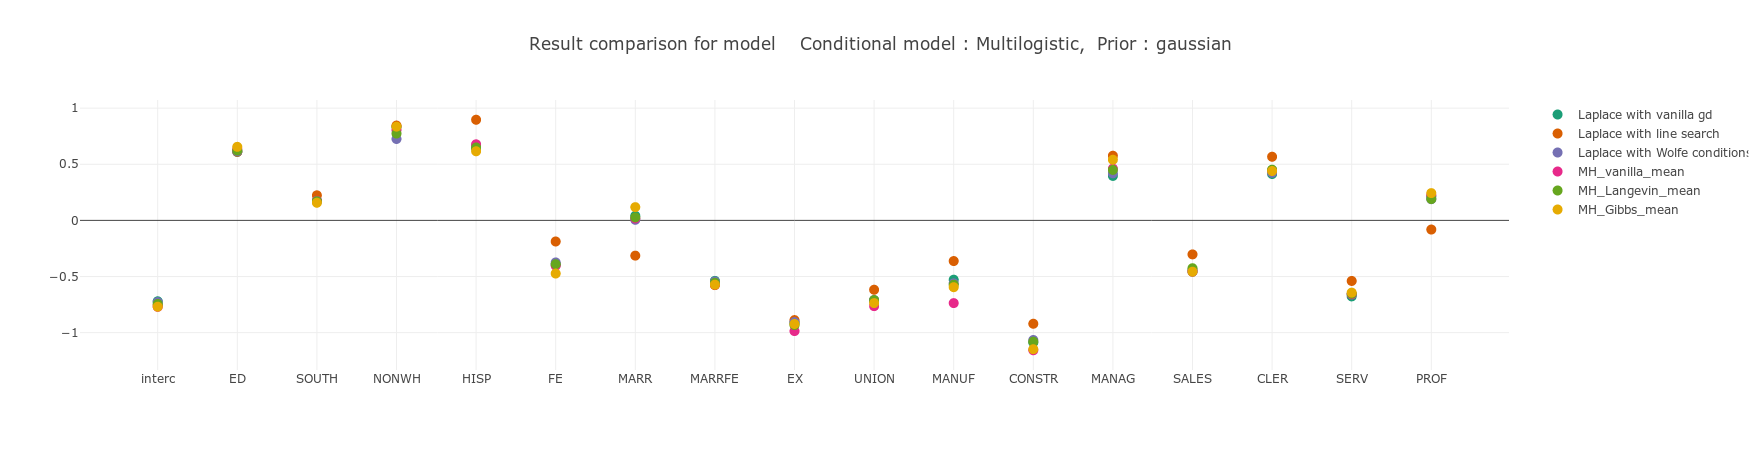

In [42]:
visualisation(r_multilogi,multilogi)

## Results of logistic regression

In order to predict, we will minimize the misclassification error, which mean we will use the decision boundary $\mathbb{P}[Y=1|x]>=0.5$.

Following Bishop _Pattern recognition and Machine learning_, p.220, we first compute the MAP of our parameter $\beta$, and then use it to predict our classes using the decisin boundary above.

In [72]:
predictions = multilogi.predict(X_intercept_test)
fitted = multilogi.predict(X_intercept)

In [73]:
errors = {}

In [74]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes_test):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes_test))
    else:
        errors[name] = [error/len(classes_test)]

In [75]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes))
    else:
        errors[name] = [error/len(classes)]

In [76]:
errors = pd.DataFrame(errors)
errors.index = ["error on test", "error on train"]
errors.T

error on test  error on train
Laplace with vanilla gd             0.280374        0.121780
Laplace with line search            0.261682        0.117096
Laplace with Wolfe conditions       0.280374        0.121780
MH_vanilla_mean                     0.280374        0.121780
MH_Langevin_mean                    0.280374        0.121780
MH_Gibbs_mean                       0.280374        0.121780

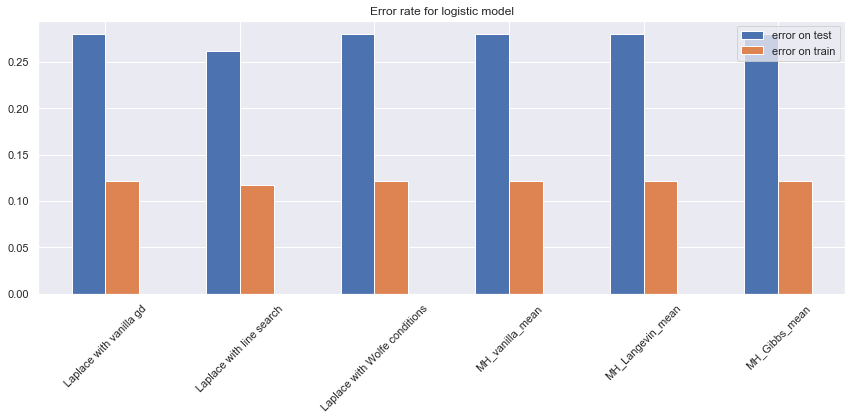

In [77]:
big_plot(12,6)
errors.T.plot.bar()
plt.xticks(rotation=45)
plt.title("Error rate for logistic model")
plt.tight_layout()
plt.savefig("results/logistic_accuracy.png", dpi = 300,bbox_inches = "tight")
reset_plot()

In [91]:
# by simulation using the samples above:
samples = [samples_classification_gibbs[1000:,],samples_classification_langevin[1000:,],samples_classification_rw[1000:,]]
names = ["gibbs","langevn","vanilla MH"]

df_result_sampled = {}


def link(x,theta):
    return np.dot(x,theta)

for i,S in enumerate(samples):
    error_rate = 0
    for x,y in zip(X_intercept_test,classes_test):
        expo = link(x,S.T)
        proba = np.exp(expo)/(1+np.exp(expo))
        if np.sum(proba >=0.5)>np.sum(proba < 0.5):
            predict = 1
        else:
            predict = 0
        if predict != y:
            error_rate +=1 
    if i == 0:
        df_result_sampled["test"] = [error_rate/len(classes_test)]
    else:
         df_result_sampled["test"].append(error_rate/len(classes_test))

In [94]:
df_result_sampled

test
gibbs       0.280374
langevn     0.280374
vanilla MH  0.280374

So both gives the same results, but the first one is quicker 

# Comparison of time efficiency of the methods

In [49]:
models = [model_gaussian,model_student,multilogi]

In [54]:
dic_time = {}
dic_time_per_iter = {}
for m in models:
    for key,elt in m.time.items():
        if key in dic_time:
            dic_time[key].append(elt[0])
            dic_time_per_iter[key].append(elt[0]/elt[1])
        else:
            dic_time[key]=[elt[0]]
            dic_time_per_iter[key]=[elt[0]/elt[1]]


In [55]:
df_time = pd.DataFrame(dic_time)
df_time_per_iter = pd.DataFrame(dic_time_per_iter)
df_time.index = ["gaussian","student","logistic"]
df_time_per_iter.index = ["gaussian","student","logistic"]

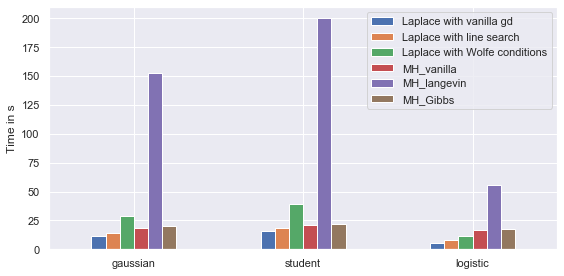

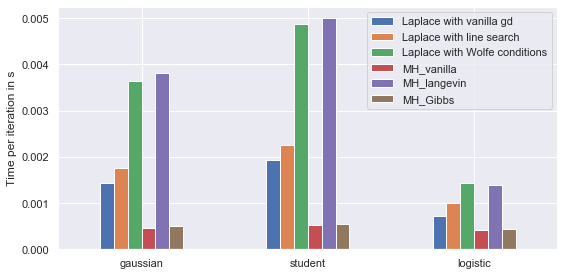

In [96]:
df_time.plot.bar()
plt.xticks(rotation="horizontal")
plt.ylabel("Time in s")
plt.tight_layout()
plt.savefig("results/time.png", dpi = 300,bbox_inches = "tight")
df_time_per_iter.plot.bar()
plt.xticks(rotation="horizontal")
plt.ylabel("Time per iteration in s")
plt.tight_layout()
plt.savefig("results/time_per_iter.png", dpi = 300,bbox_inches = "tight")